The following code imports standard python libraries

In [1]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import h5py

import torch.fft
from sklearn.manifold import TSNE
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

# following for displaying images in notebook
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

The following are the settings used, `L` and `Lf` are latent dimensions of the first and second autoencoders.
`Kc` is the number of clusters.
`Khp` is the order of k-harmonic mean cost function, usually a value in 2..4. The patch size of the images used in training is given by `patch_size`. The number of input channels XX(real,imag) YY(real,imag) is 4, it is also possible to use all 4 correlations XX,XY,YX,YY when `num_in_channels` should be 8.

In [2]:
L=256 # latent dimension
Lf=64 # latent dimension
Kc=10 # clusters
Khp=4 # order of K harmonic mean 1/|| ||^p norm

patch_size=128
num_in_channels=4 # real,imag XX,YY
# enable this to create psuedocolor images using all XX and YY
colour_output=True

We import the neural networks models used here

In [3]:
from lofar_models import *


We create the models and initialize them with the saved models.

In [4]:
net=AutoEncoderCNN2(latent_dim=L,channels=num_in_channels)
# fft: real,imag, so increase number of channels by x2
fnet=AutoEncoderCNN2(latent_dim=Lf,channels=2*num_in_channels)
mod=Kmeans(latent_dim=(L+Lf),p=Khp)

checkpoint=torch.load('./net.model',map_location=torch.device('cpu'))
net.load_state_dict(checkpoint['model_state_dict'])
checkpoint=torch.load('./fnet.model',map_location=mydevice)
fnet.load_state_dict(checkpoint['model_state_dict'])
checkpoint=torch.load('./khm.model',map_location=torch.device('cpu'))
mod.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Display the clustering model

In [5]:
torchvision.utils.save_image(mod.M.data,'M.png')
Image('M.png')

Specify data files here, I used a list of h5 files and a matching list of SAP Ids.

In [6]:
file_list=['/home/sarod/L785751.MS_extract.h5','/home/sarod/L785751.MS_extract.h5',
   '/home/sarod/L785747.MS_extract.h5', '/home/sarod/L785757.MS_extract.h5',
   '/home/sarod/L696315.MS_extract.h5', '/home/sarod/L696315.MS_extract.h5',
   '/home/sarod/L686974.MS_extract.h5', '/home/sarod/L686974.MS_extract.h5']
sap_list=['1','2','0','0','1','2','1','2']


which_sap=2 # valid in file_list/sap_list

Get the dimensions of the dataset

In [14]:
# get nbase,nfreq,ntime,npol,ncomplex
nbase,nfreq,ntime,npol,ncomplex=get_metadata(file_list[which_sap],sap_list[which_sap])
# limit the max number of baselines if time is limited
nbase=100

Create storage for creating t-SNE plot later

In [15]:
X=np.zeros([Kc,nbase],dtype=np.float)
clusid=np.zeros(nbase,dtype=np.float)

Iterate over the baselines, load each baseline as a minibatch, feed it to the network, and get clustering weights.

In [16]:
for nb in range(nbase):
    patchx,patchy,x=get_data_for_baseline(file_list[which_sap],sap_list[which_sap],baseline_id=nb,patch_size=128,num_channels=num_in_channels)
    # get latent variable
    xhat,mu=net(x)
    # perform 2D fft
    fftx=torch.fft.fftn(x-xhat,dim=(2,3),norm='ortho')
    # fftshift
    freal,fimag=torch_fftshift(fftx.real,fftx.imag)
    y=torch.cat((freal,fimag),1)
     # clamp high values data
    y.clamp_(min=-10,max=10)
    yhat,ymu=fnet(y)
    if not colour_output:
        torchvision.utils.save_image( torch.cat((torch.cat((x[0,1],xhat[0,1])),(patch_size*patch_size)*torch.cat((y[0,1],yhat[0,1]))),1).data, 'xx_'+str(nb)+'.png' )
    else:
        x0=channel_to_rgb(x[0])
        xhat0=channel_to_rgb(xhat[0])
        y0=channel_to_rgb(y[0,0:4])
        yhat0=channel_to_rgb(yhat[0,0:4])
        torchvision.utils.save_image( torch.cat((torch.cat((x0,xhat0),1),torch.cat((y0,yhat0),1)),2).data, 'xx_'+str(nb)+'.png' )
    Mu=torch.cat((mu,ymu),1)
    kdist=mod(Mu)
    (nbatch,_)=Mu.shape
    dist=torch.zeros(Kc)
    for ck in range(Kc):
        for cn in range(nbatch):
            dist[ck]=dist[ck]+(torch.norm(Mu[cn,:]-mod.M[ck,:],2))
    dist=dist/nbatch
    X[:,nb]=dist.detach().numpy()
    (values,indices)=torch.min(dist.view(Kc,1),0)
    print('%d %f %d'%(nb,kdist,indices[0]))
    clusid[nb]=indices[0]
    vis=get_data_for_baseline_flat(file_list[which_sap],sap_list[which_sap],baseline_id=nb,num_channels=num_in_channels)
    if not colour_output:
        torchvision.utils.save_image(vis[0,0].data, 'b'+str(indices[0].data.item())+'_'+str(nb)+'.png')
    else:
        torchvision.utils.save_image(channel_to_rgb(vis[0]), 'b'+str(indices[0].data.item())+'_'+str(nb)+'.png')

0 0.000034 0
1 0.000033 0
2 0.000108 0
3 0.000197 0
4 0.000031 0
5 0.000044 0
6 0.000041 8
7 0.000052 8
8 0.000058 0
9 0.000107 0
10 0.000057 8
11 0.000053 0
12 0.000036 0
13 0.000042 0
14 0.000030 0
15 0.000051 0
16 0.000070 0
17 0.000086 0
18 0.000029 0
19 0.000063 0
20 0.000108 0
21 0.000172 0
22 0.000173 0
23 0.000125 0
24 0.000098 0
25 0.000156 0
26 0.000233 0
27 0.000210 0
28 0.000082 0
29 0.000108 0
30 0.000029 0
31 0.000024 8
32 0.000106 0
33 0.000099 0
34 0.000040 0
35 0.000042 0
36 0.000067 8
37 0.000068 8
38 0.000053 0
39 0.000036 8
40 0.000172 0
41 0.000143 0
42 0.000058 8
43 0.000052 8
44 0.000045 8
45 0.000053 8
46 0.000032 0
47 0.000031 8
48 0.000191 8
49 0.000197 8
50 0.000345 8
51 0.000577 8
52 0.000255 8
53 0.000130 8
54 0.000305 8
55 0.000536 8
56 0.000139 8
57 0.000188 8
58 0.000686 8
59 0.000217 8
60 0.000123 8
61 0.000239 8
62 0.000301 8
63 0.000388 8
64 0.000213 8
65 0.000244 0
66 0.000227 2
67 0.000248 8
68 0.000340 2
69 0.000195 7
70 0.000253 7
71 0.000189 7
72

554 0.000188 2
555 0.000490 8
556 0.000216 2
557 0.000150 2
558 0.000309 5
559 0.000300 2
560 0.000278 8
561 0.000299 2
562 0.000290 8
563 0.000437 7
564 0.000305 2
565 0.000305 2
566 0.000105 7
567 0.000354 7
568 0.000137 7
569 0.000089 7
570 0.000002 2
571 0.000192 2
572 0.000034 0
573 0.000070 0
574 0.000035 0
575 0.000071 0
576 0.000019 0
577 0.000007 0
578 0.000139 0
579 0.000156 0
580 0.000157 0
581 0.000133 0
582 0.000334 0
583 0.000416 7
584 0.000063 0
585 0.000035 0
586 0.000342 7
587 0.000368 7
588 0.000070 0
589 0.000043 0
590 0.000036 0
591 0.000033 0
592 0.000127 0
593 0.000068 0
594 0.000265 0
595 0.000286 0
596 0.000078 0
597 0.000093 0
598 0.000125 0
599 0.000097 0
600 0.000082 7
601 0.000093 7
602 0.000146 0
603 0.000217 0
604 0.000035 0
605 0.000032 0
606 0.000049 8
607 0.000046 8
608 0.000134 0
609 0.000197 0
610 0.000310 0
611 0.000287 0
612 0.000187 8
613 0.000184 2
614 0.000434 8
615 0.000712 2
616 0.000302 8
617 0.000113 8
618 0.000371 8
619 0.000455 2
620 0.0001

1094 0.000057 0
1095 0.000084 0
1096 0.000048 0
1097 0.000040 0
1098 0.000098 0
1099 0.000104 0
1100 0.000030 8
1101 0.000019 5
1102 0.000027 0
1103 0.000055 0
1104 0.000100 0
1105 0.000110 0
1106 0.000062 8
1107 0.000058 8
1108 0.000023 0
1109 0.000055 0
1110 0.000077 0
1111 0.000084 0
1112 0.000189 8
1113 0.000177 8
1114 0.000358 8
1115 0.000655 8
1116 0.000297 8
1117 0.000130 8
1118 0.000343 8
1119 0.000541 8
1120 0.000164 8
1121 0.000178 8
1122 0.000709 8
1123 0.000205 8
1124 0.000114 8
1125 0.000278 8
1126 0.000329 2
1127 0.000391 8
1128 0.000263 8
1129 0.000278 0
1130 0.000337 7
1131 0.000324 8
1132 0.000371 2
1133 0.000190 7
1134 0.000337 7
1135 0.000201 7
1136 0.000065 2
1137 0.000015 7
1138 0.000207 8
1139 0.000034 0
1140 0.000123 0
1141 0.000185 0
1142 0.000033 0
1143 0.000051 0
1144 0.000397 7
1145 0.000341 0
1146 0.000038 0
1147 0.000056 0
1148 0.000112 0
1149 0.000094 0
1150 0.000030 0
1151 0.000040 0
1152 0.000082 0
1153 0.000082 0
1154 0.000038 0
1155 0.000033 0
1156 0.0

1608 0.000610 8
1609 0.000209 5
1610 0.000111 8
1611 0.000303 8
1612 0.000301 2
1613 0.000308 8
1614 0.000293 2
1615 0.000297 0
1616 0.000407 7
1617 0.000326 2
1618 0.000331 2
1619 0.000130 7
1620 0.000370 7
1621 0.000149 7
1622 0.000091 7
1623 0.000003 2
1624 0.000218 2
1625 0.000034 0
1626 0.000041 0
1627 0.000034 7
1628 0.000026 7
1629 0.000017 7
1630 0.000016 7
1631 0.000042 7
1632 0.000047 7
1633 0.000356 7
1634 0.000381 7
1635 0.000034 8
1636 0.000031 8
1637 0.000023 7
1638 0.000024 7
1639 0.000070 7
1640 0.000068 7
1641 0.000053 8
1642 0.000049 8
1643 0.000029 7
1644 0.000024 7
1645 0.000015 7
1646 0.000011 7
1647 0.000207 2
1648 0.000167 2
1649 0.000540 2
1650 0.000579 2
1651 0.000307 2
1652 0.000094 8
1653 0.000392 2
1654 0.000386 2
1655 0.000191 8
1656 0.000124 2
1657 0.000359 2
1658 0.000213 2
1659 0.000083 8
1660 0.000281 2
1661 0.000172 2
1662 0.000164 0
1663 0.000249 2
1664 0.000277 2
1665 0.000303 7
1666 0.000248 2
1667 0.000183 7
1668 0.000043 7
1669 0.000294 7
1670 0.0

2123 0.000667 8
2124 0.000291 8
2125 0.000124 8
2126 0.000377 8
2127 0.000542 8
2128 0.000172 8
2129 0.000186 8
2130 0.000507 8
2131 0.000201 8
2132 0.000124 8
2133 0.000262 0
2134 0.000336 2
2135 0.000315 8
2136 0.000272 8
2137 0.000276 8
2138 0.000374 7
2139 0.000295 8
2140 0.000337 2
2141 0.000169 7
2142 0.000312 7
2143 0.000207 7
2144 0.000064 2
2145 0.000015 7
2146 0.000179 8
2147 0.000034 0
2148 0.000044 0
2149 0.000066 0
2150 0.000066 0
2151 0.000056 8
2152 0.000052 8
2153 0.000028 0
2154 0.000042 0
2155 0.000086 0
2156 0.000107 0
2157 0.000175 8
2158 0.000166 8
2159 0.000345 8
2160 0.000674 8
2161 0.000299 8
2162 0.000123 8
2163 0.000368 8
2164 0.000519 8
2165 0.000171 8
2166 0.000180 8
2167 0.000623 8
2168 0.000199 8
2169 0.000115 8
2170 0.000278 8
2171 0.000331 2
2172 0.000367 8
2173 0.000273 8
2174 0.000284 0
2175 0.000381 7
2176 0.000334 8
2177 0.000355 2
2178 0.000171 7
2179 0.000341 7
2180 0.000199 7
2181 0.000071 7
2182 0.000011 2
2183 0.000201 8
2184 0.000034 0
2185 0.0

2637 0.000054 7
2638 0.000002 2
2639 0.000097 2
2640 0.000034 0
2641 0.000332 8
2642 0.000451 8
2643 0.000530 8
2644 0.000370 8
2645 0.000538 8
2646 0.000254 8
2647 0.000480 2
2648 0.000558 2
2649 0.000431 2
2650 0.000353 8
2651 0.000430 7
2652 0.000360 2
2653 0.000161 7
2654 0.000101 7
2655 0.000331 7
2656 0.000157 7
2657 0.000019 7
2658 0.000006 2
2659 0.000106 8
2660 0.000034 0
2661 0.000233 7
2662 0.000583 8
2663 0.000189 8
2664 0.000154 0
2665 0.000297 8
2666 0.000355 7
2667 0.000414 2
2668 0.000443 2
2669 0.000197 8
2670 0.000381 7
2671 0.000310 2
2672 0.000233 7
2673 0.000123 7
2674 0.000342 7
2675 0.000164 7
2676 0.000071 7
2677 0.000002 2
2678 0.000190 2
2679 0.000034 0
2680 0.000571 8
2681 0.000161 8
2682 0.000154 0
2683 0.000238 8
2684 0.000439 7
2685 0.000509 8
2686 0.000340 2
2687 0.000191 8
2688 0.000298 7
2689 0.000312 2
2690 0.000227 7
2691 0.000230 7
2692 0.000263 7
2693 0.000241 7
2694 0.000053 7
2695 0.000014 7
2696 0.000154 2
2697 0.000034 0
2698 0.000519 7
2699 0.0

Display some of the results first

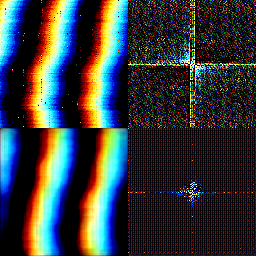

In [17]:
Image('xx_51.png')

Create t-SNE plot

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2850 samples in 0.004s...
[t-SNE] Computed neighbors for 2850 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2850
[t-SNE] Computed conditional probabilities for sample 2000 / 2850
[t-SNE] Computed conditional probabilities for sample 2850 / 2850
[t-SNE] Mean sigma: 0.004059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.074562
[t-SNE] KL divergence after 1000 iterations: 0.489718


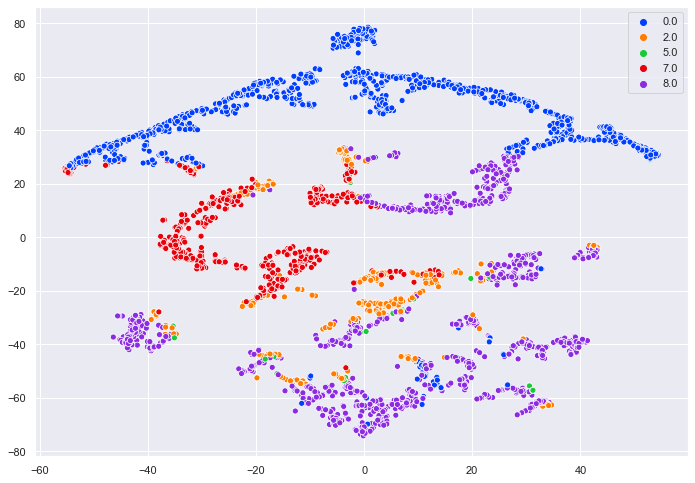

In [18]:
tsne=TSNE(verbose=True)
X_emb=tsne.fit_transform(X.transpose())
uniq=np.unique(clusid)
snsplot=sns.scatterplot(X_emb[:,0], X_emb[:,1], hue=clusid, legend='full',
  palette = sns.color_palette("bright", n_colors=len(uniq)))
snsplot.figure.savefig('scatter.png')

Find the closest and farthest clusters, by averaging cluster distance over all data. The lowest values indicate that features corresponding to each of these clusters are detected in the data.

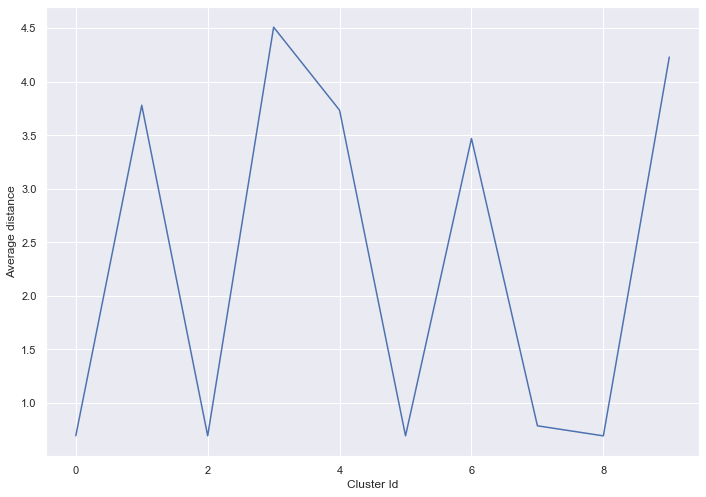

In [19]:
xm=np.mean(X,axis=1)
plt.xlabel('Cluster Id')
plt.ylabel('Average distance')
plt.plot(xm)